# Modeling and Simulation in Python

Chapter 21

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [70]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### With air resistance

Next we'll add air resistance using the [drag equation](https://en.wikipedia.org/wiki/Drag_equation)

I'll start by getting the units we'll need from Pint.

In [71]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Now I'll create a `Params` object to contain the quantities we need.  Using a Params object is convenient for grouping the system parameters in a way that's easy to read (and double-check).

In [72]:
params = Params(height = 381 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 2.5e-3 * kg,
                diameter = 19e-3 * m,
                rho = 1.2 * kg/m**3,
                v_term = 18 * m / s)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

`make_system` uses the given radius to compute `area` and the given `v_term` to compute the drag coefficient `C_d`.

In [73]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    area = np.pi * (diameter/2)**2
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=height, v=v_init)
    t_end = 30 * s
    
    return System(params, area=area, C_d=C_d, 
                  init=init, t_end=t_end)

Let's make a `System`

In [74]:
system = make_system(params)

,values
height,381 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,0.0025 kilogram
diameter,0.019 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
area,0.0002835287369864788 meter ** 2
C_d,0.4445009981135434 dimensionless
init,y 381 meter v 0.0 meter / secon...


Here's the slope function, including acceleration due to gravity and drag.

In [75]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

As always, let's test the slope function with the initial conditions.

In [76]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

We can use the same event function as last time.

In [77]:
def event_func(state, t, system):
    """Return the height of the penny above the sidewalk.
    """
    y, v = state
    return y

And then run the simulation.

In [78]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

Here are the results.

In [79]:
results

,y,v
0.000000,3.810000e+02,0.000000
0.000102,3.810000e+02,-0.001000
0.001122,3.810000e+02,-0.011000
0.011327,3.809994e+02,-0.110998
0.113367,3.809371e+02,-1.109588
1.133773,3.750650e+02,-9.886284
2.336542,3.593541e+02,-15.381283
3.679032,3.370777e+02,-17.358218
5.021521,3.133656e+02,-17.847263
6.657291,2.840359e+02,-17.971703


The final height is close to 0, as expected.

Interestingly, the final velocity is not exactly terminal velocity, which suggests that there are some numerical errors.

We can get the flight time from `results`.

In [80]:
t_sidewalk = get_last_label(results)

22.439075231128985

Here's the plot of position as a function of time.

Saving figure to file figs/chap09-fig02.pdf


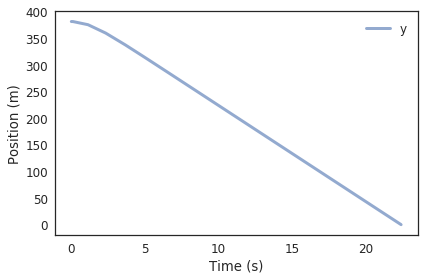

In [81]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)
savefig('figs/chap09-fig02.pdf')

And velocity as a function of time:

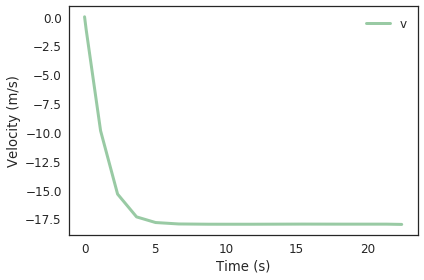

In [82]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

From an initial velocity of 0, the penny accelerates downward until it reaches terminal velocity; after that, velocity is constant.

**Exercise:** Run the simulation with an initial velocity, downward, that exceeds the penny's terminal velocity.  Hint: You can create a new `Params` object based on an existing one, like this:

`params = Params(params, v_init = -30 * m / s)`

What do you expect to happen?  Plot velocity and position as a function of time, and see if they are consistent with your prediction.

In [83]:
# Solution

params = Params(params, v_init = -30 * m / s)
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

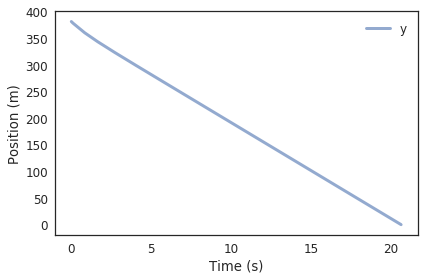

In [84]:
plot_position(results)

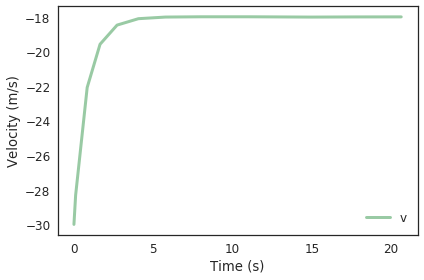

In [85]:
# Solution

plot_velocity(results)

**Exercise:** Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds.  Use this measurement to estimate the terminal velocity.

1. You can get the relevant dimensions of a quarter from https://en.wikipedia.org/wiki/Quarter_(United_States_coin).

2. Create a `Params` object with the system parameters.  We don't know `v_term`, so we'll start with the inital guess `v_term = 18 * m / s`.

3. Use `make_system` to create a `System` object.

4. Call `run_ode_solver` to simulate the system.  How does the flight time of the simulation compare to the measurement?

5. Try a few different values of `t_term` and see if you can get the simulated flight time close to 19.1 seconds.

6. Optionally, write an error function and use `fsolve` to improve your estimate.

7. Use your best estimate of `v_term` to compute `C_d`.

Note: I fabricated the observed flight time, so don't take the results of this exercise too seriously.

In [86]:
# Solution

# Here's a `Params` object with the dimensions of a quarter,
# the observed flight time and our initial guess for `v_term`

params = Params(params,
                mass = 5.67e-3 * kg,
                diameter = 24.26e-3 * m,
                v_term = 18 * m / s,
                flight_time = 19.1 * s)

,values
height,381 meter
v_init,-30.0 meter / second
g,9.8 meter / second ** 2
mass,0.00567 kilogram
diameter,0.02426 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
flight_time,19.1 second


In [87]:
# Solution

# Now we can make a `System` object

system = make_system(params)

,values
height,381 meter
v_init,-30.0 meter / second
g,9.8 meter / second ** 2
mass,0.00567 kilogram
diameter,0.02426 meter
rho,1.2 kilogram / meter ** 3
v_term,18.0 meter / second
flight_time,19.1 second
area,0.000462244204111976 meter ** 2
C_d,0.6183600157463346 dimensionless


In [90]:
# Solution

# And run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
message,A termination event occurred.
nfev,74
njev,0
nlu,0
sol,None
status,1
success,True
t_events,[[20.63532743663445]]


In [91]:
# Solution

# And get the flight time

flight_time = get_last_label(results) * s

<Quantity(20.63532743663445, 'second')>

In [95]:
# Solution

# The flight time is a little long, so we could increase `v_term` and try again.

# Or we could write an error function

def error_func(v_term, params):
    """Final height as a function of C_d.
    
    C_d: drag coefficient
    params: Params object
    
    returns: height in m
    """
    params = Params(params, v_term=v_term)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    flight_time = get_last_label(results) * s
    return flight_time - params.flight_time

In [96]:
# Solution

# We can test the error function like this

guess = 18 * m / s
error_func(guess, params)

<Quantity(1.53532743663445, 'second')>

In [97]:
# Solution

# Now we can use `fsolve` to find the value of `v_term` that yields the measured flight time.

solution = fsolve(error_func, guess, params)
v_term_solution = solution[0] * m/s

<Quantity(19.459701937716446, 'meter / second')>

In [98]:
# Solution

# Plugging in the estimated value, we can use `make_system` to compute `C_d`

params = Params(params, v_term=v_term_solution)
system = make_system(params)
system.C_d

<Quantity(0.5290711032106973, 'dimensionless')>

### Bungee jumping

Suppose you want to set the world record for the highest "bungee dunk", [as shown in this video](https://www.youtube.com/watch?v=UBf7WC19lpw).  Since the record is 70 m, let's design a jump for 80 m.

We'll make the following modeling assumptions:

1. Initially the bungee cord hangs from a crane with the attachment point 80 m above a cup of tea.

2. Until the cord is fully extended, it applies no force to the jumper.  It turns out this might not be a good assumption; we will revisit it.

3. After the cord is fully extended, it obeys [Hooke's Law](https://en.wikipedia.org/wiki/Hooke%27s_law); that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length.

4. The jumper is subject to drag force proportional to the square of their velocity, in the opposite of their direction of motion.

Our objective is to choose the length of the cord, `L`, and its spring constant, `k`, so that the jumper falls all the way to the tea cup, but no farther! 

First I'll create a `Param` object to contain the quantities we'll need:

1. Let's assume that the jumper's mass is 75 kg.

2. With a terminal velocity of 60 m/s.

3. The length of the bungee cord is `L = 40 m`.

4. The spring constant of the cord is `k = 20 N / m` when the cord is stretched, and 0 when it's compressed.


In [99]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

In [159]:
params = Params(y_attach = 80 * m,
                v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                mass = 75 * kg,
                area = 1 * m**2,
                rho = 1.2 * kg/m**3,
                v_term = 60 * m / s,
                L = 25 * m,
                k = 40 * N / m)

,values
y_attach,80 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [183]:
def make_system(params):
    """Makes a System object for the given params.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=y_attach, v=v_init)
    t_end = 30 * s

    return System(params, C_d=C_d, 
                  init=init, t_end=t_end)

Let's make a `System`

In [184]:
system = make_system(params)
system

,values
y_attach,80 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter
C_d,0.3402777777777778 dimensionless


`spring_force` computes the force of the cord on the jumper:

In [192]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system|
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    unpack(system)
    distance_fallen = y_attach - y
    if distance_fallen <= L:
        return 0 * N
    
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring

The spring force is 0 until the cord is fully extended.  When it is extended 1 m, the spring force is 40 N. 

In [193]:
spring_force(80*m, system)

<Quantity(0, 'newton')>

In [194]:
spring_force(55*m, system)

<Quantity(0, 'newton')>

In [195]:
spring_force(54*m, system)

<Quantity(40.0, 'newton')>

`drag_force` computes drag as a function of velocity:

In [219]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    
    returns: drag force
    """
    unpack(system)
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

Now here's the slope function:

In [220]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    unpack(system)
    
    a_drag = drag_force(v, system) / mass
    a_spring = spring_force(y, system) / mass
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt

As always, let's test the slope function with the initial params.

In [221]:
slope_func(system.init, 0, system)

(<Quantity(0.0, 'meter / second')>, <Quantity(-9.8, 'meter / second ** 2')>)

And then run the simulation.

In [222]:
ts = linspace(0, system.t_end, 301)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
details

,values
message,The solver successfully reached the interval end.
nfev,236
njev,0
nlu,0
sol,None
status,0
success,True
t_events,[]


Here's the plot of position as a function of time.

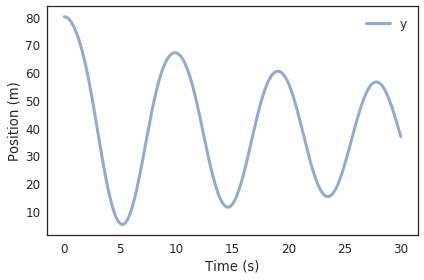

In [223]:
plot_position(results)

After reaching the lowest point, the jumper springs back almost to almost 70 m, and oscillates several times.  That looks like more osciallation that we expect from an actual jump, which suggests that there some dissipation of energy in the real world that is not captured in our model.  To improve the model, that might be a good thing to investigate.

But since we are primarily interested in the initial descent, the model might be good enough for now.

We can use `min` to find the lowest point:

In [218]:
min(results.y)

5.1799703464989335

At the lowest point, the jumper is still too high, so we'll need to increase `L` or decrease `k`.

Here's velocity as a function of time:

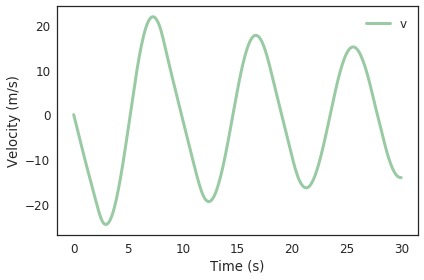

In [203]:
plot_velocity(results)

Saving figure to file figs/chap09-fig03.pdf


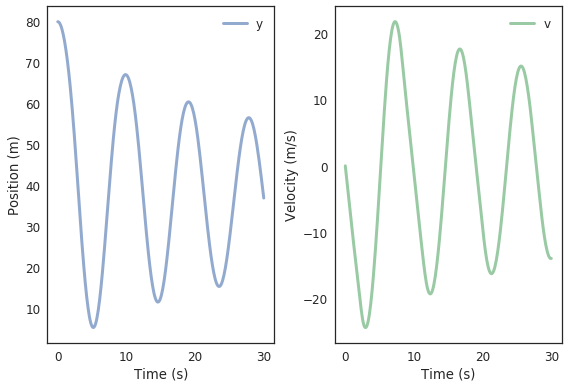

In [204]:
subplot(1, 2, 1)
plot_position(results)

subplot(1, 2, 2)
plot_velocity(results)

savefig('figs/chap09-fig03.pdf')

Although we compute acceleration inside the slope function, we don't get acceleration as a result from `run_ode_solver`.

We can approximate it by computing the numerical derivative of `ys`:

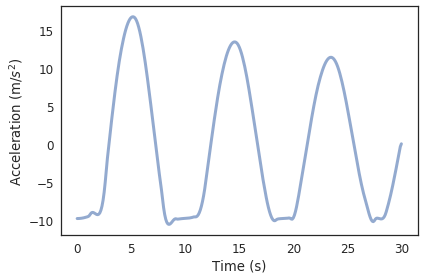

In [205]:
a = gradient(results.v)
plot(a)
decorate(xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)')

And we can compute the maximum acceleration the jumper experiences:

In [206]:
max_acceleration = max(a) * m/s**2

<Quantity(16.75079725304155, 'meter / second ** 2')>

Relative to the acceleration of gravity, the jumper "pulls" about "1.7 g's".

In [208]:
max_acceleration / g

<Quantity(1.7092650258205664, 'dimensionless')>

### Solving for length

Assuming that `k` is fixed, let's find the length `L` that makes the minimum altitude of the jumper exactly 0.

Here's the error function:

In [35]:
def error_func(L, params):
    """Minimum height as a function of length.
    
    length: length in m
    params: Params object
    
    returns: height in m
    """
    params = Params(params, L=L)
    system = make_system(params)

    ts = linspace(0, system.t_end, 201)
    results, details = run_ode_solver(system, slope_func, t_eval=ts)
    min_height = min(results.y)
    return min_height

Let's test it with the same initial guess, `L = 100 m`:

In [36]:
guess = 150 * m
error_func(guess, params)

119.14568330523029

And find the value of `L` we need for the world record jump:

In [37]:
solution = fsolve(error_func, guess, params)

array([260.78574921])

**Optional:** Search for the combination of length and spring constant that yields minimum height 0 while minimizing peak acceleration.

In [38]:
# Solution

ks = np.linspace(1, 31, 11) * N / m

for k in ks:
    guess = 250 * m
    params = Params(params, k=k)
    solution = fsolve(error_func, guess, params)
    L = solution[0] * m
    params = Params(params, L=L)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, t_eval=ts)
    a = gradient(results.v)
    g_max = max(a) * m/s**2 / g
    print(k, L, g_max)

1.0 newton / meter -483.1429396908503 meter 0.17584604083333497 dimensionless
4.0 newton / meter 70.54780511680855 meter 0.6912121734141764 dimensionless
7.0 newton / meter 161.1541432460714 meter 1.0914235802924046 dimensionless
10.0 newton / meter 202.17405449658656 meter 1.435864054193015 dimensionless
13.0 newton / meter 227.86005853679828 meter 1.7065736435639631 dimensionless
16.0 newton / meter 243.97203228964753 meter 1.9887775175403402 dimensionless
19.0 newton / meter 257.30496940959637 meter 2.204636494160503 dimensionless
22.0 newton / meter 265.7902447183497 meter 2.4453581682255328 dimensionless
25.0 newton / meter 274.91575508305107 meter 2.607142045194042 dimensionless
28.0 newton / meter 281.1809127600765 meter 2.799398587830593 dimensionless
31.0 newton / meter 286.360055638525 meter 2.994252693587456 dimensionless


**Optional exercise:** This model neglects the weight of the bungee cord, which might be non-negligible.  Implement the [model described here](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007) and see how different it is from our simplified model. 

### Under the hood

The gradient function in `modsim.py` adapts the NumPy function of the same name so it works with `Series` objects.


In [39]:
%psource gradient

def gradient(series):
    """Computes the numerical derivative of a series."""
    a = np.gradient(series, series.index)
    return TimeSeries(a, series.index)
